### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd 

import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 

import string
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn import metrics

from time import time

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Analysis of Data

In [2]:
data = pd.read_csv('/kaggle/input/newdata/DATASET2.csv')
display(data.shape) 

(255, 3)

In [ ]:
data.head()

In [4]:
data["label"].value_counts()

Approved    198
Pending      44
Reject       13
Name: label, dtype: int64

In [5]:
# data.replace('Pending','Reject', inplace = True)
# data["label"].value_counts()

In [6]:
data.replace('Approved',0, inplace = True)
data.replace('Pending',1, inplace = True)
data.replace('Reject',2, inplace = True)

data.label

0      1
1      0
2      0
3      0
4      0
      ..
250    2
251    2
252    2
253    2
254    2
Name: label, Length: 255, dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    255 non-null    object
 1   label   255 non-null    int64 
 2   text    255 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.1+ KB


## Text Pre-processing

In [8]:
# data['relevance'] = data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0 
temp = data[["text","label"]] # taking text input and output variable as relevance
temp = temp[:1000]
temp.shape

(255, 2)

In [ ]:
data = temp
data

### Text Cleaning

In [10]:
import spacy
nlp = spacy.load('en_core_web_sm')

stopwords = stop_words.ENGLISH_STOP_WORDS
lemmatizer = WordNetLemmatizer()

def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    doc = (" ".join(text_no_namedentities))

    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ") 
    doc = doc.replace("-", " ") 
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])    
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    return doc

In [ ]:
data['text'] = data['text'].apply(clean)
data.head()

### TF-IDF

In [12]:
docs = list(data['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [13]:
X = docs 
y = data['label']
print(X.shape, y.shape)

(255, 4605) (255,)


In [14]:
fig = go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])
fig.update_layout(
    title="Values in each label",
    xaxis_title="label",
    yaxis_title="Values")
fig.show()

### Train-Test Split

In [15]:
SEED=123
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(204, 4605) (204,)
(51, 4605) (51,)


In [16]:
y.value_counts()

0    198
1     44
2     13
Name: label, dtype: int64

In [17]:
y_train.value_counts()

0    159
1     35
2     10
Name: label, dtype: int64

## no sampling

**Gaussian Naive Bayes**

CPU times: user 13.3 ms, sys: 7.9 ms, total: 21.2 ms
Wall time: 19.3 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7843137254901961
              precision    recall  f1-score   support

    Approved       0.78      1.00      0.88        39
     Pending       1.00      0.11      0.20         9
      Reject       0.00      0.00      0.00         3

    accuracy                           0.78        51
   macro avg       0.59      0.37      0.36        51
weighted avg       0.77      0.78      0.71        51



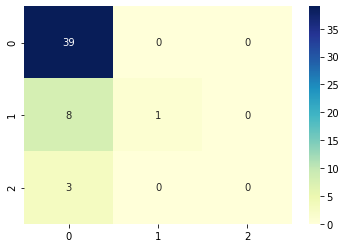

In [18]:
gnb = GaussianNB() 
%time gnb.fit(X_train, y_train)

y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Multinomial Naive Bayes**

CPU times: user 6.17 ms, sys: 70 µs, total: 6.24 ms
Wall time: 4.51 ms

Training Accuracy score: 0.7794117647058824
Testing Accuracy score: 0.7647058823529411
              precision    recall  f1-score   support

    Approved       0.76      1.00      0.87        39
     Pending       0.00      0.00      0.00         9
      Reject       0.00      0.00      0.00         3

    accuracy                           0.76        51
   macro avg       0.25      0.33      0.29        51
weighted avg       0.58      0.76      0.66        51



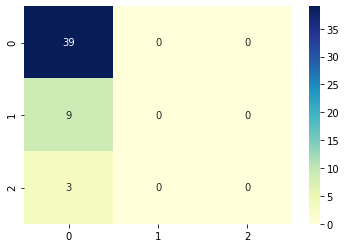

In [19]:
mnb = MultinomialNB() 
%time mnb.fit(X_train, y_train)

y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Logistic Regression**

CPU times: user 162 ms, sys: 7.09 ms, total: 170 ms
Wall time: 97.7 ms

Training Accuracy score: 0.7794117647058824
Testing Accuracy score: 0.7647058823529411
              precision    recall  f1-score   support

    Approved       0.76      1.00      0.87        39
     Pending       0.00      0.00      0.00         9
      Reject       0.00      0.00      0.00         3

    accuracy                           0.76        51
   macro avg       0.25      0.33      0.29        51
weighted avg       0.58      0.76      0.66        51



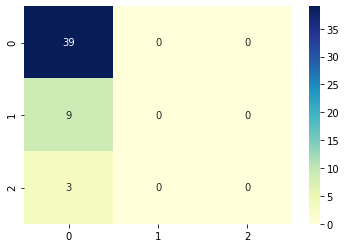

In [20]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**SVM**

CPU times: user 14.3 ms, sys: 3.02 ms, total: 17.3 ms
Wall time: 16.7 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7843137254901961
              precision    recall  f1-score   support

    Approved       0.78      1.00      0.88        39
     Pending       1.00      0.11      0.20         9
      Reject       0.00      0.00      0.00         3

    accuracy                           0.78        51
   macro avg       0.59      0.37      0.36        51
weighted avg       0.77      0.78      0.71        51



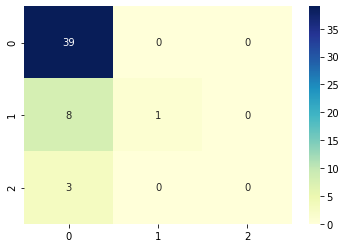

In [21]:
svc =  LinearSVC(class_weight='balanced') 
%time svc.fit(X_train, y_train)

y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Decision Tree**

CPU times: user 91.2 ms, sys: 1.01 ms, total: 92.2 ms
Wall time: 93.2 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.6078431372549019
              precision    recall  f1-score   support

    Approved       0.78      0.74      0.76        39
     Pending       0.18      0.22      0.20         9
      Reject       0.00      0.00      0.00         3

    accuracy                           0.61        51
   macro avg       0.32      0.32      0.32        51
weighted avg       0.63      0.61      0.62        51



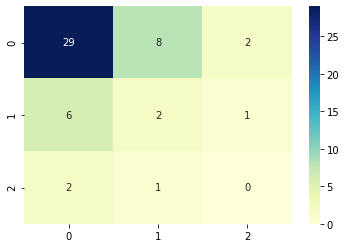

In [22]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

## upsampling

In [23]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train,y_train)
print(len(X_train_sm))
y_train_sm.value_counts()

477


2    159
1    159
0    159
Name: label, dtype: int64

**Gaussian Naive Bayes**

CPU times: user 59.5 ms, sys: 11 ms, total: 70.5 ms
Wall time: 34.5 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7843137254901961
              precision    recall  f1-score   support

    Approved       0.78      1.00      0.88        39
     Pending       1.00      0.11      0.20         9
      Reject       0.00      0.00      0.00         3

    accuracy                           0.78        51
   macro avg       0.59      0.37      0.36        51
weighted avg       0.77      0.78      0.71        51



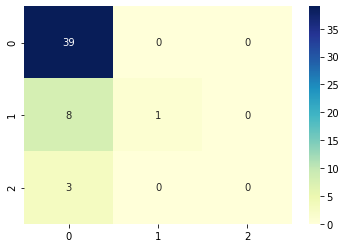

In [24]:
gnb = GaussianNB() 
%time gnb.fit(X_train_sm, y_train_sm)

y_pred_train = gnb.predict(X_train_sm)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_sm, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Multinomial Naive Bayes**

CPU times: user 10.4 ms, sys: 0 ns, total: 10.4 ms
Wall time: 7.7 ms

Training Accuracy score: 0.9706498951781971
Testing Accuracy score: 0.6078431372549019
              precision    recall  f1-score   support

    Approved       0.92      0.62      0.74        39
     Pending       0.29      0.67      0.40         9
      Reject       0.25      0.33      0.29         3

    accuracy                           0.61        51
   macro avg       0.49      0.54      0.47        51
weighted avg       0.77      0.61      0.65        51



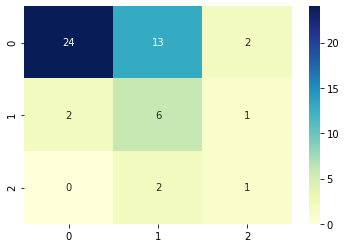

In [25]:
mnb = MultinomialNB() 
%time mnb.fit(X_train_sm, y_train_sm)

y_pred_train = mnb.predict(X_train_sm)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_sm, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Logistic Regression**

CPU times: user 363 ms, sys: 6.01 ms, total: 369 ms
Wall time: 196 ms

Training Accuracy score: 0.9979035639412998
Testing Accuracy score: 0.7450980392156863
              precision    recall  f1-score   support

    Approved       0.77      0.95      0.85        39
     Pending       0.33      0.11      0.17         9
      Reject       0.00      0.00      0.00         3

    accuracy                           0.75        51
   macro avg       0.37      0.35      0.34        51
weighted avg       0.65      0.75      0.68        51



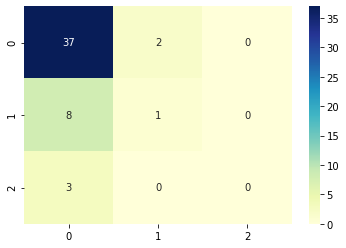

In [26]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train_sm, y_train_sm)

y_pred_train = lr.predict(X_train_sm)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_sm, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**SVM**

CPU times: user 46.1 ms, sys: 0 ns, total: 46.1 ms
Wall time: 45.4 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7843137254901961
              precision    recall  f1-score   support

    Approved       0.78      1.00      0.88        39
     Pending       1.00      0.11      0.20         9
      Reject       0.00      0.00      0.00         3

    accuracy                           0.78        51
   macro avg       0.59      0.37      0.36        51
weighted avg       0.77      0.78      0.71        51



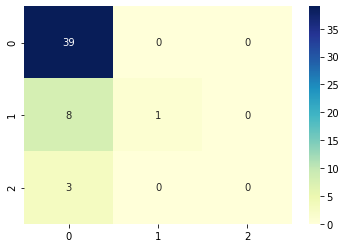

In [27]:
svc =  LinearSVC(class_weight='balanced') 
%time svc.fit(X_train_sm, y_train_sm)

y_pred_train = svc.predict(X_train_sm)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_sm, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Decision Tree**

CPU times: user 98 ms, sys: 2.94 ms, total: 101 ms
Wall time: 99.7 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.6274509803921569
              precision    recall  f1-score   support

    Approved       0.77      0.77      0.77        39
     Pending       0.17      0.22      0.19         9
      Reject       0.00      0.00      0.00         3

    accuracy                           0.63        51
   macro avg       0.31      0.33      0.32        51
weighted avg       0.62      0.63      0.62        51



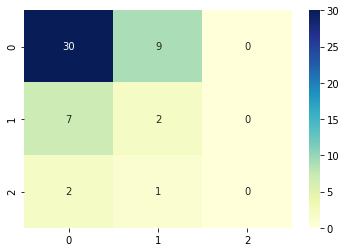

In [28]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train_sm, y_train_sm)

y_pred_train = dt.predict(X_train_sm)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_sm, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

## downsampling

In [29]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
print('Original dataset shape %s' % Counter(y_train))
rus = RandomUnderSampler(random_state=42)
X_train_ds, y_train_ds = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_ds))

Original dataset shape Counter({0: 159, 1: 35, 2: 10})
Resampled dataset shape Counter({0: 10, 1: 10, 2: 10})


**Gaussian Naive Bayes**

CPU times: user 3.83 ms, sys: 1.99 ms, total: 5.82 ms
Wall time: 4.32 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.5490196078431373
              precision    recall  f1-score   support

    Approved       0.83      0.62      0.71        39
     Pending       0.23      0.33      0.27         9
      Reject       0.11      0.33      0.17         3

    accuracy                           0.55        51
   macro avg       0.39      0.43      0.38        51
weighted avg       0.68      0.55      0.60        51



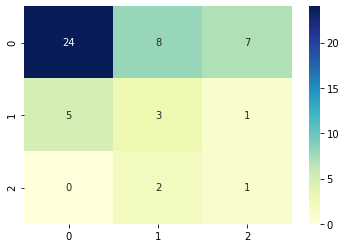

In [30]:
gnb = GaussianNB() 
%time gnb.fit(X_train_ds, y_train_ds)

y_pred_train = gnb.predict(X_train_ds)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ds, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Multinomial Naive Bayes**

CPU times: user 4.66 ms, sys: 980 µs, total: 5.64 ms
Wall time: 3.25 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.45098039215686275
              precision    recall  f1-score   support

    Approved       0.86      0.49      0.62        39
     Pending       0.20      0.33      0.25         9
      Reject       0.07      0.33      0.12         3

    accuracy                           0.45        51
   macro avg       0.38      0.38      0.33        51
weighted avg       0.70      0.45      0.53        51



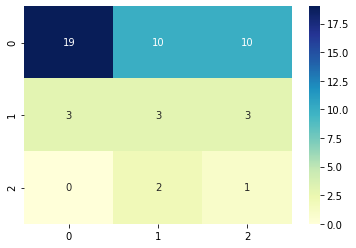

In [31]:
mnb = MultinomialNB() 
%time mnb.fit(X_train_ds, y_train_ds)

y_pred_train = mnb.predict(X_train_ds)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ds, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Logistic Regression**

CPU times: user 43.1 ms, sys: 3.95 ms, total: 47 ms
Wall time: 33.3 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.5294117647058824
              precision    recall  f1-score   support

    Approved       0.85      0.56      0.68        39
     Pending       0.24      0.44      0.31         9
      Reject       0.12      0.33      0.18         3

    accuracy                           0.53        51
   macro avg       0.40      0.45      0.39        51
weighted avg       0.70      0.53      0.58        51



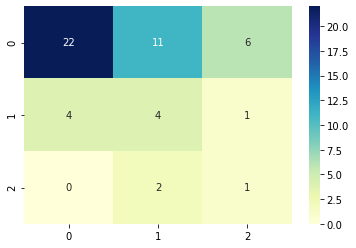

In [32]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train_ds, y_train_ds)

y_pred_train = lr.predict(X_train_ds)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ds, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**SVM**

CPU times: user 2.12 ms, sys: 1.01 ms, total: 3.13 ms
Wall time: 3.14 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.5294117647058824
              precision    recall  f1-score   support

    Approved       0.85      0.56      0.68        39
     Pending       0.24      0.44      0.31         9
      Reject       0.12      0.33      0.18         3

    accuracy                           0.53        51
   macro avg       0.40      0.45      0.39        51
weighted avg       0.70      0.53      0.58        51



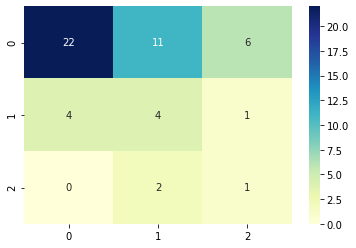

In [33]:
svc =  LinearSVC(class_weight='balanced') 
%time svc.fit(X_train_ds, y_train_ds)

y_pred_train = svc.predict(X_train_ds)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ds, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Decision Tree**

CPU times: user 8.35 ms, sys: 20 µs, total: 8.37 ms
Wall time: 8.56 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.3137254901960784
              precision    recall  f1-score   support

    Approved       0.75      0.31      0.44        39
     Pending       0.12      0.11      0.12         9
      Reject       0.11      1.00      0.20         3

    accuracy                           0.31        51
   macro avg       0.33      0.47      0.25        51
weighted avg       0.60      0.31      0.37        51



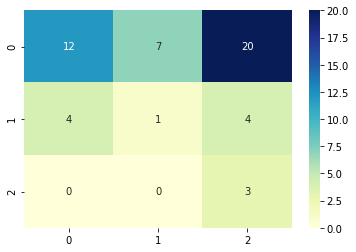

In [34]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train_ds, y_train_ds)

y_pred_train = dt.predict(X_train_ds)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ds, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

## middle value of 100

In [35]:
from imblearn.over_sampling import SMOTE

X_new = X_train
y_new = y_train
oversampler = SMOTE(sampling_strategy={1: 100})
X_resampled, y_resampled = oversampler.fit_resample(X_new, y_new)
print('Original dataset shape %s' % Counter(y_resampled))
rus = RandomUnderSampler(random_state=42)
X_train_ud, y_train_ud = rus.fit_resample(X_resampled, y_resampled)
print('Resampled dataset shape %s' % Counter(y_train_ud))

y_train_ud.value_counts()


Original dataset shape Counter({0: 159, 1: 100, 2: 10})
Resampled dataset shape Counter({0: 10, 1: 10, 2: 10})


2    10
1    10
0    10
Name: label, dtype: int64

**Gaussian Naive Bayes**

CPU times: user 3.71 ms, sys: 974 µs, total: 4.69 ms
Wall time: 3.69 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.5294117647058824
              precision    recall  f1-score   support

    Approved       0.84      0.54      0.66        39
     Pending       0.24      0.44      0.31         9
      Reject       0.22      0.67      0.33         3

    accuracy                           0.53        51
   macro avg       0.43      0.55      0.43        51
weighted avg       0.70      0.53      0.58        51



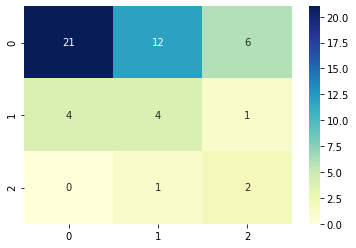

In [36]:
gnb = GaussianNB() 
%time gnb.fit(X_train_ud, y_train_ud)

y_pred_train = gnb.predict(X_train_ud)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Multinomial Naive Bayes**

CPU times: user 6.02 ms, sys: 115 µs, total: 6.14 ms
Wall time: 3.52 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.4117647058823529
              precision    recall  f1-score   support

    Approved       0.79      0.38      0.52        39
     Pending       0.18      0.33      0.23         9
      Reject       0.20      1.00      0.33         3

    accuracy                           0.41        51
   macro avg       0.39      0.57      0.36        51
weighted avg       0.65      0.41      0.46        51



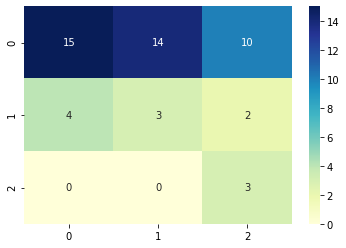

In [37]:
mnb = MultinomialNB() 
%time mnb.fit(X_train_ud, y_train_ud)

y_pred_train = mnb.predict(X_train_ud)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Logistic Regression**

CPU times: user 59.7 ms, sys: 3.15 ms, total: 62.8 ms
Wall time: 43.5 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.47058823529411764
              precision    recall  f1-score   support

    Approved       0.83      0.49      0.61        39
     Pending       0.15      0.22      0.18         9
      Reject       0.20      1.00      0.33         3

    accuracy                           0.47        51
   macro avg       0.39      0.57      0.38        51
weighted avg       0.67      0.47      0.52        51



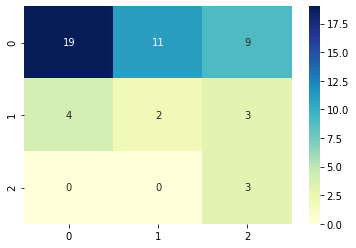

In [38]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train_ud, y_train_ud)

y_pred_train = lr.predict(X_train_ud)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**SVM**

CPU times: user 4.41 ms, sys: 23 µs, total: 4.43 ms
Wall time: 3.84 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.45098039215686275
              precision    recall  f1-score   support

    Approved       0.81      0.44      0.57        39
     Pending       0.20      0.33      0.25         9
      Reject       0.20      1.00      0.33         3

    accuracy                           0.45        51
   macro avg       0.40      0.59      0.38        51
weighted avg       0.67      0.45      0.50        51



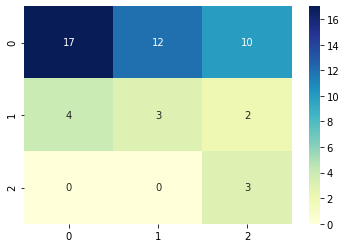

In [39]:
svc =  LinearSVC(class_weight='balanced') 
%time svc.fit(X_train_ud, y_train_ud)

y_pred_train = svc.predict(X_train_ud)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Decision Tree**

CPU times: user 5.2 ms, sys: 16 µs, total: 5.21 ms
Wall time: 4.49 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.35294117647058826
              precision    recall  f1-score   support

    Approved       0.75      0.31      0.44        39
     Pending       0.31      0.56      0.40         9
      Reject       0.05      0.33      0.09         3

    accuracy                           0.35        51
   macro avg       0.37      0.40      0.31        51
weighted avg       0.63      0.35      0.41        51



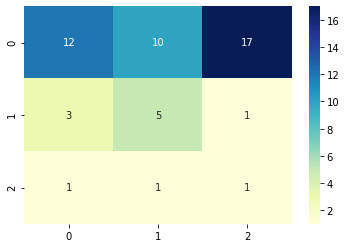

In [40]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train_ud, y_train_ud)

y_pred_train = dt.predict(X_train_ud)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

## middle value of 70

In [41]:
from imblearn.over_sampling import SMOTE

X_new = X_train
y_new = y_train
oversampler = SMOTE(sampling_strategy={1: 70})
X_resampled, y_resampled = oversampler.fit_resample(X_new, y_new)
print('Original dataset shape %s' % Counter(y_resampled))
rus = RandomUnderSampler(random_state=42)
X_train_ud, y_train_ud = rus.fit_resample(X_resampled, y_resampled)
print('Resampled dataset shape %s' % Counter(y_train_ud))

y_train_ud.value_counts()


Original dataset shape Counter({0: 159, 1: 70, 2: 10})
Resampled dataset shape Counter({0: 10, 1: 10, 2: 10})


2    10
1    10
0    10
Name: label, dtype: int64

**Gaussian Naive Bayes**

CPU times: user 4.67 ms, sys: 0 ns, total: 4.67 ms
Wall time: 3.83 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.35294117647058826
              precision    recall  f1-score   support

    Approved       0.80      0.31      0.44        39
     Pending       0.19      0.67      0.30         9
      Reject       0.00      0.00      0.00         3

    accuracy                           0.35        51
   macro avg       0.33      0.32      0.25        51
weighted avg       0.65      0.35      0.39        51



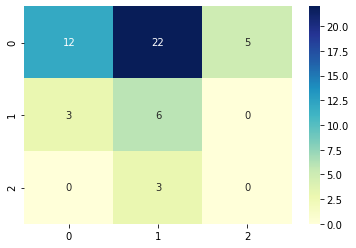

In [42]:
gnb = GaussianNB() 
%time gnb.fit(X_train_ud, y_train_ud)

y_pred_train = gnb.predict(X_train_ud)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Multinomial Naive Bayes**

CPU times: user 5.84 ms, sys: 956 µs, total: 6.79 ms
Wall time: 5.02 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.37254901960784315
              precision    recall  f1-score   support

    Approved       0.79      0.38      0.52        39
     Pending       0.13      0.22      0.17         9
      Reject       0.12      0.67      0.20         3

    accuracy                           0.37        51
   macro avg       0.35      0.42      0.29        51
weighted avg       0.63      0.37      0.44        51



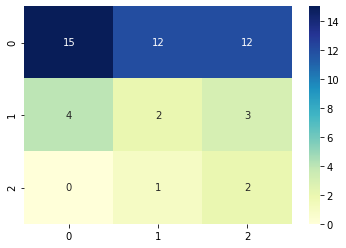

In [43]:
mnb = MultinomialNB() 
%time mnb.fit(X_train_ud, y_train_ud)

y_pred_train = mnb.predict(X_train_ud)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Logistic Regression**

CPU times: user 52.2 ms, sys: 3.06 ms, total: 55.2 ms
Wall time: 37.4 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.5098039215686274
              precision    recall  f1-score   support

    Approved       0.84      0.54      0.66        39
     Pending       0.20      0.22      0.21         9
      Reject       0.19      1.00      0.32         3

    accuracy                           0.51        51
   macro avg       0.41      0.59      0.39        51
weighted avg       0.69      0.51      0.56        51



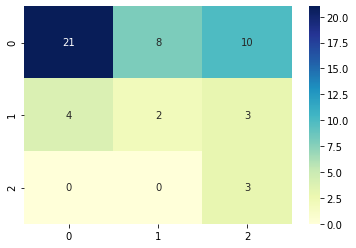

In [44]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train_ud, y_train_ud)

y_pred_train = lr.predict(X_train_ud)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**SVM**

CPU times: user 4.47 ms, sys: 27 µs, total: 4.5 ms
Wall time: 3.81 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.45098039215686275
              precision    recall  f1-score   support

    Approved       0.77      0.44      0.56        39
     Pending       0.21      0.33      0.26         9
      Reject       0.20      1.00      0.33         3

    accuracy                           0.45        51
   macro avg       0.40      0.59      0.38        51
weighted avg       0.64      0.45      0.49        51



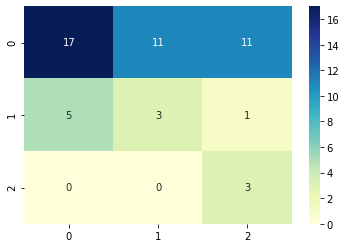

In [45]:
svc =  LinearSVC(class_weight='balanced') 
%time svc.fit(X_train_ud, y_train_ud)

y_pred_train = svc.predict(X_train_ud)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Decision Tree**

CPU times: user 6.09 ms, sys: 61 µs, total: 6.15 ms
Wall time: 5.8 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.3137254901960784
              precision    recall  f1-score   support

    Approved       0.85      0.28      0.42        39
     Pending       0.17      0.22      0.19         9
      Reject       0.12      1.00      0.21         3

    accuracy                           0.31        51
   macro avg       0.38      0.50      0.27        51
weighted avg       0.68      0.31      0.37        51



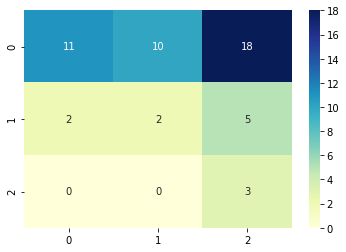

In [46]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train_ud, y_train_ud)

y_pred_train = dt.predict(X_train_ud)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Pending','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()